In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import powerlaw
from sklearn.cluster import *
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import *
from scipy import cluster
from scipy.stats import mode
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

def set_font_size(ax, font_size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size)

# Analysis of ERC-20 token networks

## Graph construction

We import the TSV file summarizing the properties of all 100 token networks. For each network we recorded the following information:

1. Number of nodes.
2. Number of edges.
3. Number of weakly connected components.
4. Time elapsed for the construction of the graph.

In [2]:
df = pd.read_csv('igraph/results/analyze_full.tsv', sep='\t')
df

,contract_id,num_nodes,num_edges,num_wcc,elapsed_time
0,0,23176194,66749187,170,65710005200
1,1,1121371,4648079,15475,3670987998
2,2,8235862,18006639,68,17260555005
3,3,1749966,4035204,873,3322112509
4,4,2374302,4198235,33,3851428348
...,...,...,...,...,...
95,95,295712,468557,36,298859025
96,96,277705,445533,2,283597615
97,97,431525,762013,1,402749145
98,98,42397,103577,145,58686749


Print the average number of nodes and edges among all 100 token networks.

In [3]:
print(f'Avg. nodes: {np.mean(df.num_nodes)}\nAvg. edges: {np.mean(df.num_edges)}')

Avg. nodes: 759003.99
Avg. edges: 1701879.33


We then print the cumulative distribution functions for the number of nodes and number of edges across all 100 graphs.

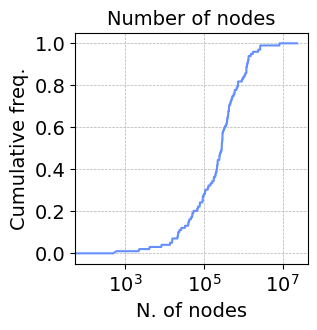

In [4]:
sizes = df.num_nodes.values
hist, bins = np.histogram(sizes, bins = np.arange(0, np.max(sizes)+1, 100))
plt.figure(figsize=(3, 3))
plt.title('Number of nodes')
plt.xlabel('N. of nodes')
plt.ylabel('Cumulative freq.')
plt.xscale('log')
plt.plot(bins[:-1], np.cumsum(hist)/np.sum(hist), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig(f"figures/cumulative_nodes.pdf", format='pdf', bbox_inches='tight')
plt.show()

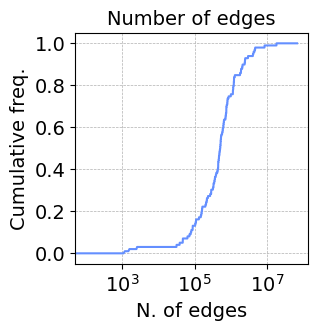

In [5]:
sizes = df.num_edges.values
hist, bins = np.histogram(sizes, bins = np.arange(0, np.max(sizes)+1, 100))
plt.figure(figsize=(3, 3))
plt.title('Number of edges')
plt.xlabel('N. of edges')
plt.ylabel('Cumulative freq.')
plt.xscale('log')
plt.plot(bins[:-1], np.cumsum(hist)/np.sum(hist), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig(f"figures/cumulative_edges.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Graph analysis

Let $G$ be a token network and $G_{LCC}$ be the subgraph induced by the nodes and edges of its largest connected component.

We associate each $G$ with seven numerical features, namely:

1. Coverage, namely the percentage of nodes of $G$ included in $G_{LCC}$.
2. Alpha, which represents the exponent of the power law distribution best fitting the degree distribution of $G_{LCC}$.
3. Fitting error, which corresponds to the error obtained during the fitting process to obtain the previously described alpha.
4. Relative diameter, which represents the ratio between the diameter of $G_{LCC}$ and the natural logarithm of the number of nodes.
5. Relative average shortest path length, which is computed as the average shortest path length of $G_{LCC}$ divided by the natural logarithm of the number of nodes.
6. Transitivity coincides with the global clustering coefficient of $G_{LCC}$, namely the ratio between the number of triangles and connected triples in the graph.
7. Density, as the ratio between the actual number of edges and the maximum possible number of edges in $G_{LCC}$.

With the previously gathered information, we now create a CSV file containing these features for each of the 100 graphs. We also associate to each network a categorical label describing the application domain of the corresponding contract.

In [4]:
cat2int = {'defi':0,'other':1,'multimedia':2,'layer-2':3,'content':4,'blockchain':5,'games':6,'storage':7,'mining':8}
comp = pd.read_csv('results/comp.csv')
fit_deg = pd.read_csv('results/fit_deg.tsv', sep='\t').rename(columns={'D':'error'})
path = pd.read_csv('webgraph/results/path.tsv', sep='\t')
stats_gcc = pd.read_csv('igraph/results/analyze_gcc.tsv', sep='\t')
contract_info = pd.read_excel('results/contracts_top_100.ods')[['contract_id', 'category']]#.fillna('other')
final = comp.merge(fit_deg, on='contract_id', how='left') \
    .merge(path, on='contract_id', how='left') \
    .merge(stats_gcc, on='contract_id', how='left') \
    .merge(contract_info, on='contract_id', how='left')
final['category_id'] = final['category'].map(cat2int)
final = final[['contract_id', 'category', 'category_id', 'comp_nodes', 'coverage', 'alpha', 'error', 'diameter', 'est_apl', 'transitivity', 'density']]
final['est_apl'] /= np.log(final['comp_nodes'])
final['diameter'] /= np.log(final['comp_nodes'])
final.to_csv('results/final.csv', index=False)

In [2]:
features = ['coverage', 'alpha', 'error', 'diameter', 'est_apl', 'transitivity', 'density'] # List of features used for clustering
final = pd.read_csv('results/final.csv')
final

,contract_id,category,category_id,comp_nodes,coverage,alpha,error,diameter,est_apl,transitivity,density
0,0,defi,0,23175878,0.999986,2.140207,0.008764,2.948353,0.218610,0.000015,2.485440e-07
1,1,defi,0,1093419,0.975073,2.069239,0.007478,2.085608,0.274730,0.006812,7.754500e-06
2,2,defi,0,8235742,0.999985,2.642766,0.006713,3.893496,0.255894,0.000015,5.309530e-07
3,3,defi,0,1747934,0.998839,2.512690,0.005704,2.226250,0.287544,0.000093,2.640710e-06
4,4,other,1,2374247,0.999977,2.958134,0.012375,1.634856,0.299280,0.000019,1.489510e-06
...,...,...,...,...,...,...,...,...,...,...,...
95,95,other,1,295637,0.999746,3.590946,0.018918,1.587694,0.295035,0.000073,1.072110e-05
96,96,other,1,277703,0.999993,3.367225,0.026177,1.994526,0.309367,0.000046,1.155450e-05
97,97,storage,7,431525,1.000000,14.250211,0.014759,0.308283,0.193321,0.000015,8.184300e-06
98,98,defi,0,42109,0.993207,2.659823,0.015098,5.822681,0.305624,0.000562,1.166670e-04


We first print the mean values for each of the seven features of interest.

In [3]:
final[features].mean()

coverage        0.981182
alpha           3.848506
error           0.022407
diameter        1.553374
est_apl         0.274752
transitivity    0.000355
density         0.000207
dtype: float64

Then we plot their distributions using histograms.

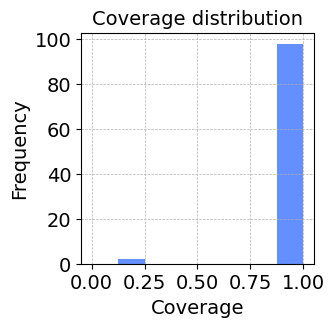

In [7]:
data = final['coverage']
plt.figure(figsize=(3, 3))
plt.title('Coverage distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.hist(data, bins=np.arange(0.0, 1.0+0.125, step=0.125), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_coverage_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

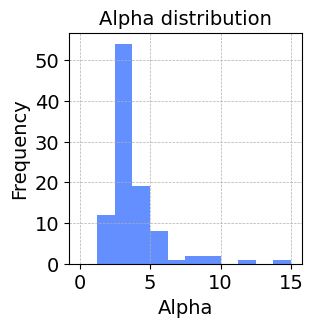

In [8]:
data = final['alpha']
plt.figure(figsize=(3, 3))
plt.title('Alpha distribution')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.hist(data, bins=np.arange(0.0, 15.0+1.25, step=1.25), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_alpha_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

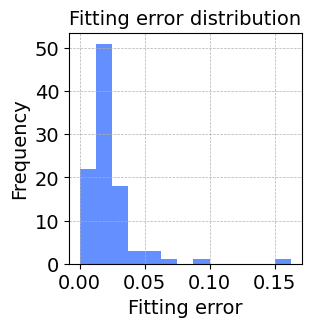

In [9]:
data = final['error']
plt.figure(figsize=(3, 3))
plt.title('Fitting error distribution')
plt.xlabel('Fitting error')
plt.ylabel('Frequency')
plt.hist(data, bins=np.arange(0.0, 0.155+0.0125, step=0.0125), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_error_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

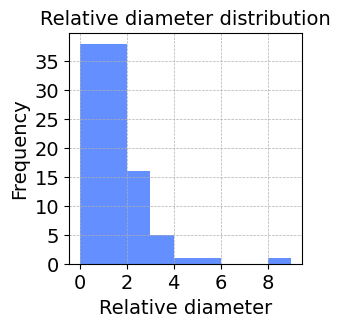

In [10]:
data = final['diameter']
plt.figure(figsize=(3, 3))
plt.title('Relative diameter distribution')
plt.xlabel('Relative diameter')
plt.ylabel('Frequency')
plt.hist(data, bins=np.arange(0, np.max(data)+1), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_diameter_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

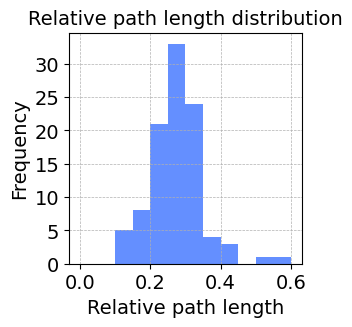

In [11]:
data = final['est_apl']
plt.figure(figsize=(3, 3))
plt.title('Relative path length distribution')
plt.xlabel('Relative path length')
plt.ylabel('Frequency')
plt.hist(data, bins=np.arange(0, 65, 5) / 100, color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_apl_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

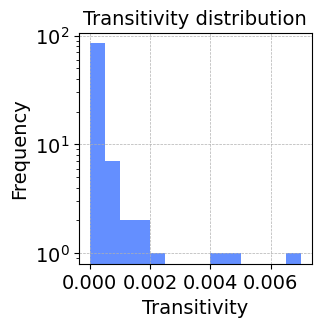

In [12]:
data = final['transitivity']
plt.figure(figsize=(3, 3))
plt.title('Transitivity distribution')
plt.xlabel('Transitivity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.hist(data, bins=np.arange(0, 0.007 + 0.0005, step=0.0005), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_transitivity_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

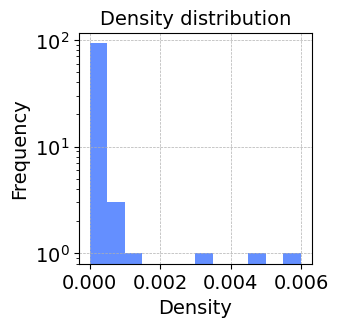

In [13]:
data = final['density']
plt.figure(figsize=(3, 3))
plt.title('Density distribution')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.yscale('log')
plt.hist(data, bins=np.arange(0, 0.006 + 0.0005, step=0.0005), color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig("figures/feature_density_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Clustering

In this section we analyze the results of our clustering analysis.

### K-Means

We start by importing the CSV file including all configurations tested with the K-Means algorithm.
This file has one row for each configuration and each configuration is described by the following attributes.

1. List of features used for the clustering.
2. Number of clusters $k$.
3. Silhouette score of the clustering.
4. Homogeneity score of the clustering (computed w.r.t. the manual labeling describing the contract semantics).


In [2]:
kmeans_results = pd.read_csv('results/kmeans.csv')
kmeans_results

,features,k,silhouette,homogeneity
0,coverage,2,0.945020,0.019125
1,coverage,3,0.936986,0.045896
2,coverage,4,0.919401,0.063349
3,coverage,5,0.915470,0.063349
4,coverage,6,0.904286,0.063349
...,...,...,...,...
2408,coverage alpha error diameter est_apl transiti...,16,0.242082,0.324247
2409,coverage alpha error diameter est_apl transiti...,17,0.239250,0.342884
2410,coverage alpha error diameter est_apl transiti...,18,0.223565,0.357724
2411,coverage alpha error diameter est_apl transiti...,19,0.226103,0.357851


We now proceed as follows.

1. We select the best configuration for each feature subset, in accordance with the silhouette score.
2. We select the top 3 configurations yielding the highest silhouette score.
3. We visualize (with a bar plot) the compositions of clusters in these 3 configurations.

In [6]:
x = kmeans_results.sort_values("silhouette", ascending=False).groupby("features", as_index=False).first()
x.sort_values("silhouette", ascending=False).head(3)

,features,k,silhouette,homogeneity
32,coverage,2,0.945020,0.019125
96,density,2,0.834273,0.023512
65,coverage density,2,0.784913,0.019125


For the last step, we define the following function in order to build the plots.

In [8]:
def plot_clustering(features, k, filename = None):
    features_str = ' '.join(features)
    clust_data = PowerTransformer().fit_transform(final[features])
    #clust_data = StandardScaler().fit_transform(final[features])
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=1000, random_state=1)
    pred_labels = kmeans.fit_predict(clust_data)
    sil = silhouette_score(clust_data, pred_labels)
    result = pd.DataFrame(clust_data).assign(label = pred_labels)
    plt.figure(figsize=(3, 3))
    plt.title(f'Features: [{features_str}]\nSilhouette: {round(sil, 6)}')
    sns.countplot(x='label', color='#648fff', data=result)
    plt.xlabel('Cluster ID')
    plt.ylabel('N. of contracts')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    set_font_size(plt.gca(), 14)
    if (not (filename is None)):
        plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()

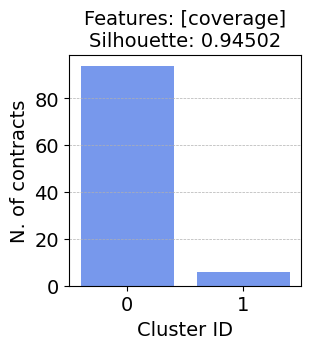

In [11]:
plot_clustering(['coverage'], 2, 'figures/kmeans-top-1.pdf')

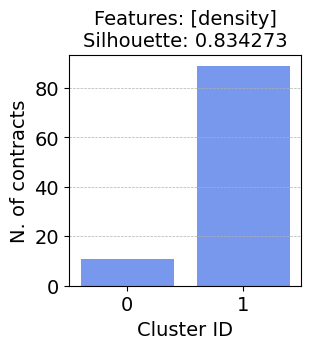

In [12]:
plot_clustering(['density'], 2, 'figures/kmeans-top-2.pdf')

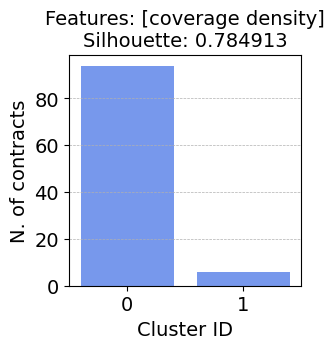

In [13]:
plot_clustering(['coverage', 'density'], 2, 'figures/kmeans-top-3.pdf')

### PCA

We conduct further analysis based on dimensionality reduction. In particular:

1. We use principal component analysis to reduce the number of features.
2. We execute the K-means algorithm on this reduced data set.

Before applying the dimensionality reduction we use the _explained variance ratio_ method to determine the optimal number of components.

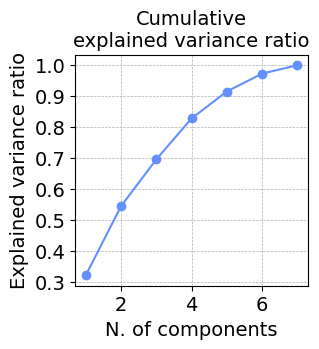

In [4]:
data = StandardScaler().fit_transform(final[features])
pca = PCA()
pca.fit(data)
plt.figure(figsize=(3, 3))
plt.title('Cumulative\nexplained variance ratio')
plt.xlabel('N. of components')
plt.ylabel('Explained variance ratio')
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker='o', color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig('figures/pca-explained-variance.pdf', format='pdf', bbox_inches='tight')
plt.show()

We select $n=4$ as the optimal number of components (preserving at least 80\% of the orginal variance) and then execute K-means for different values of $k$ (i.e., ranging from 2 to 20, included). Below, we print the silhouette scores obtained for different values of $k$.

In [5]:
data = StandardScaler().fit_transform(final[features])
pca = PCA(n_components=4)
X = pca.fit_transform(data)
kmin = 2
kmax = 20
sil = []
for k in np.arange(kmin, kmax+1):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=1000, random_state=1)
    pred_labels = kmeans.fit_predict(X)
    sil.append(silhouette_score(X, pred_labels))
result = pd.DataFrame({'k' : np.arange(kmin, kmax+1), 'silhouette' : sil})
result

,k,silhouette
0,2,0.742822
1,3,0.324028
2,4,0.351192
3,5,0.363918
4,6,0.366482
5,7,0.370663
6,8,0.363037
7,9,0.349904
8,10,0.379631
9,11,0.315155


Then we plot the silhouette scores obtained for different values of $k$.

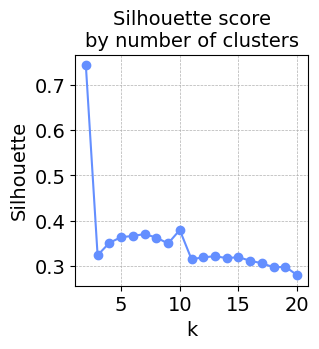

In [6]:
plt.figure(figsize=(3, 3))
plt.title('Silhouette score\nby number of clusters')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.plot(result.k, result.silhouette, marker='o', color='#648fff')
plt.grid(linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig('figures/pca-silhouette.pdf', format='pdf', bbox_inches='tight')
plt.show()

The following plot illustrates the configuration (i.e., $k=2$) yielding the best silhouette score on the reduced data set.

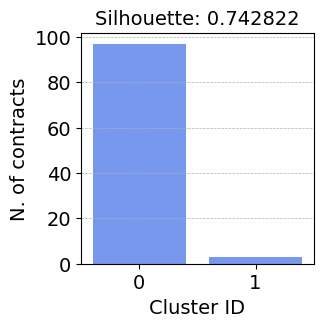

In [8]:
data = StandardScaler().fit_transform(final[features])
pca = PCA(n_components=4)
X = pca.fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=100, max_iter=1000, random_state=1)
pred_labels = kmeans.fit_predict(X)
sil = silhouette_score(X, pred_labels)
result = pd.DataFrame(X).assign(label = pred_labels)#.assign(category = final.category)
plt.figure(figsize=(3, 3))
plt.title(f'Silhouette: {round(sil, 6)}')
sns.countplot(x='label', color='#648fff', data=result)
plt.xlabel('Cluster ID')
plt.ylabel('N. of contracts')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
set_font_size(plt.gca(), 14)
plt.savefig('figures/pca-clustering.pdf', format='pdf', bbox_inches='tight')
plt.show()

The cluster composition is, however, highly imbalanced.

In [ ]:
result.label.value_counts()

### Categorization

We manually assign to each contract (i.e., each network) a categorical label describing its main application domain.

1. defi comprises all tokens related to decentralized finance (e.g., stablecoins, wrapped tokens, tokens issued by exchanges and automated market makers, etc.);
2. games includes all token related to games; 
3. blockchain denotes all tokens related to independent blockchain projects; 
4. layer-2 contains tokens related to layer-2 solutions aimed at improving the scalability of Ethereum; 
5. content includes reward tokens related to content creation platforms; 
6. storage represents all tokens related to decentralized storage solutions; 
7. mining indicates tokens associated with cryptocurrency mining services; 
8. multimedia comprises all tokens related to multimedia content (e.g., music, video streaming services, etc.); 
9. other comprises all tokens whose ap- plication domain is not included into any of the previous categories.

In [2]:
final = pd.read_csv('results/final.csv')
final

,contract_id,category,category_id,comp_nodes,coverage,alpha,error,diameter,est_apl,transitivity,density
0,0,defi,0,23175878,0.999986,2.140207,0.008764,2.948353,0.218610,0.000015,2.485440e-07
1,1,defi,0,1093419,0.975073,2.069239,0.007478,2.085608,0.274730,0.006812,7.754500e-06
2,2,defi,0,8235742,0.999985,2.642766,0.006713,3.893496,0.255894,0.000015,5.309530e-07
3,3,defi,0,1747934,0.998839,2.512690,0.005704,2.226250,0.287544,0.000093,2.640710e-06
4,4,other,1,2374247,0.999977,2.958134,0.012375,1.634856,0.299280,0.000019,1.489510e-06
...,...,...,...,...,...,...,...,...,...,...,...
95,95,other,1,295637,0.999746,3.590946,0.018918,1.587694,0.295035,0.000073,1.072110e-05
96,96,other,1,277703,0.999993,3.367225,0.026177,1.994526,0.309367,0.000046,1.155450e-05
97,97,storage,7,431525,1.000000,14.250211,0.014759,0.308283,0.193321,0.000015,8.184300e-06
98,98,defi,0,42109,0.993207,2.659823,0.015098,5.822681,0.305624,0.000562,1.166670e-04


We count how many elements belong to each of the categories.

In [3]:
final.category.value_counts()

category
defi          54
other         15
games          9
blockchain     5
layer-2        4
content        4
storage        4
mining         3
multimedia     2
Name: count, dtype: int64

Now, let us all K-means configurations obtained for $k=8$. Among them we select:

1. The one yielding the maximum silhouette score.
2. The one yielding the maximum homogeneity score.

In [16]:
kmeans_results = pd.read_csv('results/kmeans.csv')
kmeans_results_8 = kmeans_results[kmeans_results.k == 8]
max_sil = kmeans_results_8[kmeans_results_8.silhouette == np.max(kmeans_results_8.silhouette)]
max_hom = kmeans_results_8[kmeans_results_8.homogeneity == np.max(kmeans_results_8.homogeneity)]

In [21]:
max_sil

,features,k,silhouette,homogeneity
6,coverage,8,0.899257,0.092461


In [22]:
max_hom

,features,k,silhouette,homogeneity
576,coverage alpha est_apl,8,0.339005,0.253853


We now plot the subdivision of clusters for these two configurations.

The following bar plots illustrate the composition of each cluster with respect to our manual classification.

In [40]:
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors)
categories = final.category_id.values
k = 8

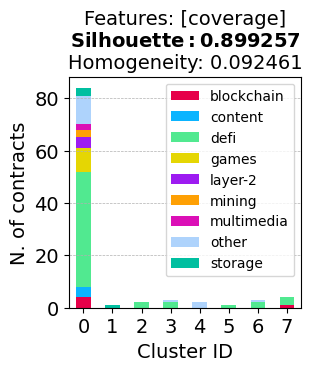

In [41]:
features = ['coverage']
features_str = ' '.join(features)
clust_data = PowerTransformer().fit_transform(final[features])
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=1000, random_state=1)
pred_labels = kmeans.fit_predict(clust_data)
sil = silhouette_score(clust_data, pred_labels)
hom = homogeneity_score(categories, pred_labels)
result = pd.DataFrame(clust_data).assign(label = pred_labels).assign(category = final.category.values)

fig, ax = plt.subplots(figsize=(3, 3))
pd.crosstab(result.label, result.category).plot(kind='bar', stacked=True, ax = ax, cmap=cmap)
ax.set_title(f'Features: [{features_str}]\n' + r'$\bf{Silhouette: {' + str(round(sil, 6)) + r'}}$' + f'\nHomogeneity: {round(hom, 6)}')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('N. of contracts')
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.legend(loc='upper right')
set_font_size(ax, 14)
plt.savefig('figures/hom-1.pdf', format='pdf', bbox_inches='tight')
plt.show()

This is the subdivision of clusters for the configuration yielding the maximum homogeneity score.

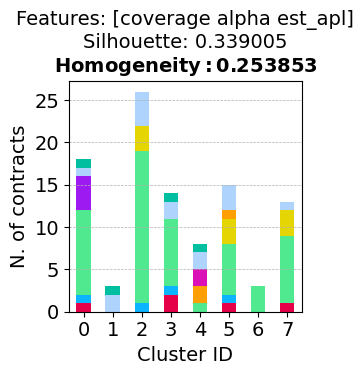

In [42]:
features = ['coverage', 'alpha', 'est_apl']
features_str = ' '.join(features)
clust_data = PowerTransformer().fit_transform(final[features])
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=1000, random_state=1)
pred_labels = kmeans.fit_predict(clust_data)
sil = silhouette_score(clust_data, pred_labels)
hom = homogeneity_score(categories, pred_labels)
result = pd.DataFrame(clust_data).assign(label = pred_labels).assign(category = final.category.values)

fig, ax = plt.subplots(figsize=(3, 3))
pd.crosstab(result.label, result.category).plot(kind='bar', stacked=True, ax = ax, cmap=cmap)
ax.set_title(f'Features: [{features_str}]\nSilhouette: {round(sil, 6)}\n' + r'$\bf{Homogeneity: {' + str(round(hom, 6)) + r'}}$')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('N. of contracts')
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.get_legend().remove()
set_font_size(ax, 14)
plt.savefig('figures/hom-2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Finally, we also plot the cluster subdivision for the configuration obtained with $k=8$ on the PCA-reduced data set.

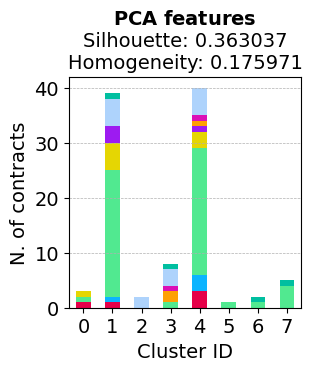

In [43]:
features = ['coverage', 'alpha', 'error', 'diameter', 'est_apl', 'transitivity', 'density']
data = StandardScaler().fit_transform(final[features])
pca = PCA(n_components=4)
X = pca.fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=100, max_iter=1000, random_state=1)
pred_labels = kmeans.fit_predict(X)
sil = silhouette_score(X, pred_labels)
hom = homogeneity_score(categories, pred_labels)
result = pd.DataFrame(data).assign(label = pred_labels).assign(category = final.category.values)
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title(r"$\bf{PCA\ features}$" + f"\nSilhouette: {round(sil, 6)}\nHomogeneity: {round(hom, 6)}")
pd.crosstab(result.label, result.category).plot(kind='bar', stacked=True, ax = ax, cmap=cmap)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('N. of contracts')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.get_legend().remove()
set_font_size(ax, 14)
plt.savefig('figures/hom-3.pdf', format='pdf', bbox_inches='tight')
plt.show()